#### Обработка данных

In [1]:
import pandas as pd
import numpy as np

import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import cross_validation, linear_model, metrics

from scipy import optimize as opt

import statsmodels.stats.api as sms

import scipy.odr as odr

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('experiment.csv') # Считываем данные

In [3]:
data.head(5) # Посмотрим на несколько значений

,feature1,feature2
0,0.07,0.27
1,0.12,0.35
2,0.20,0.45
3,0.27,0.52
4,0.32,0.57


Сгенерируем новые признаки и значения измерений, вычислим ошибки и определимся с размерностями в данных

$d = 0.16 \ cm$

$sigma_d^{syst} = 0.01 \ cm$

$s = 42 \ cm^2$

$sigma_s^{syst} = 1 \ cm^2$

$\epsilon^{syst}_m = 0.03 $

$sigma^{syst}_u = 0.02 \ V$ 

In [4]:
d = 0.16 
sigma_syst_d = 0.01
s = 42 
sigma_syst_s = 1
epsilon_syst_m = 0.03
sigma_syst_u = 20

feature1 = $m, \ g$

feature2 = $U_{isu}, \ V$ ($kV$)

feature3 = $F, \ N$ = feature1 $\cdot 10^{-2}$

feature4 = $U_{isu}^2, \ B^2$

feature5 = $2 d \sqrt{\frac{2 \pi F}{S}}, \ g^{1/2} {cm}^{1/2} s^{-1} \ = \ U_{cgs}$

feature6 = $\sigma_F^{syst} \ = \ 0.03 \cdot feature3$ 

feature7 = $\sigma_{U^2}^{syst} \ = \ 2U \sigma^{syst}_u $

feature8 = $\sigma_{U_{cgs}}^{syst}$

In [5]:
data['feature1'] = data['feature1']
data['feature2'] = data['feature2']*1000
data.insert(2, 'feature3', data['feature1']*0.01)
data.insert(3, 'feature4', data['feature2']*data['feature2'])
data.insert(4, 'feature5', data['feature3'].apply(np.sqrt)*2*d*sqrt(2*pi/s*100000))
data.insert(5, 'feature6', data['feature3']*epsilon_syst_m)
data.insert(6, 'feature7', sigma_syst_u * 2 * data['feature2'])
data.insert(7, 'feature8', data['feature5']*(1/d*sigma_syst_d + 1/(data['feature3']+s)*0.5))
data.insert(8, 'empty', 1)

In [6]:
data

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,empty
0,0.07,270,0.0007,72900,1.035534,0.000021,10800,0.077048,1
1,0.12,350,0.0012,122500,1.355832,0.000036,14000,0.100880,1
2,0.20,450,0.0020,202500,1.750372,0.000060,18000,0.130235,1
3,0.27,520,0.0027,270400,2.033748,0.000081,20800,0.151319,1
4,0.32,570,0.0032,324900,2.214064,0.000096,22800,0.164735,1
5,0.37,610,0.0037,372100,2.380763,0.000111,24400,0.177138,1
6,0.42,650,0.0042,422500,2.536529,0.000126,26000,0.188727,1
7,0.47,710,0.0047,504100,2.683269,0.000141,28400,0.199644,1
8,0.55,730,0.0055,532900,2.902663,0.000165,29200,0.215967,1
9,0.65,730,0.0065,532900,3.155527,0.000195,29200,0.234780,1


Удалим 9 и 10 измерения в силу выброса, далее этот факт будет рассмотрен подробнее

In [7]:
data_e = data[8:10] # data_e массив из этих двух значений
data = data.drop([9,8])

In [8]:
data

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,empty
0,0.07,270,0.0007,72900,1.035534,0.000021,10800,0.077048,1
1,0.12,350,0.0012,122500,1.355832,0.000036,14000,0.100880,1
2,0.20,450,0.0020,202500,1.750372,0.000060,18000,0.130235,1
3,0.27,520,0.0027,270400,2.033748,0.000081,20800,0.151319,1
4,0.32,570,0.0032,324900,2.214064,0.000096,22800,0.164735,1
5,0.37,610,0.0037,372100,2.380763,0.000111,24400,0.177138,1
6,0.42,650,0.0042,422500,2.536529,0.000126,26000,0.188727,1
7,0.47,710,0.0047,504100,2.683269,0.000141,28400,0.199644,1
10,0.17,380,0.0017,144400,1.613763,0.000051,15200,0.120071,1
11,0.65,770,0.0065,592900,3.155527,0.000195,30800,0.234780,1


In [9]:
data_e

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,empty
8,0.55,730,0.0055,532900,2.902663,0.000165,29200,0.215967,1
9,0.65,730,0.0065,532900,3.155527,0.000195,29200,0.234780,1


#### Визуализация и информация о данных

Изобразим полученные данные

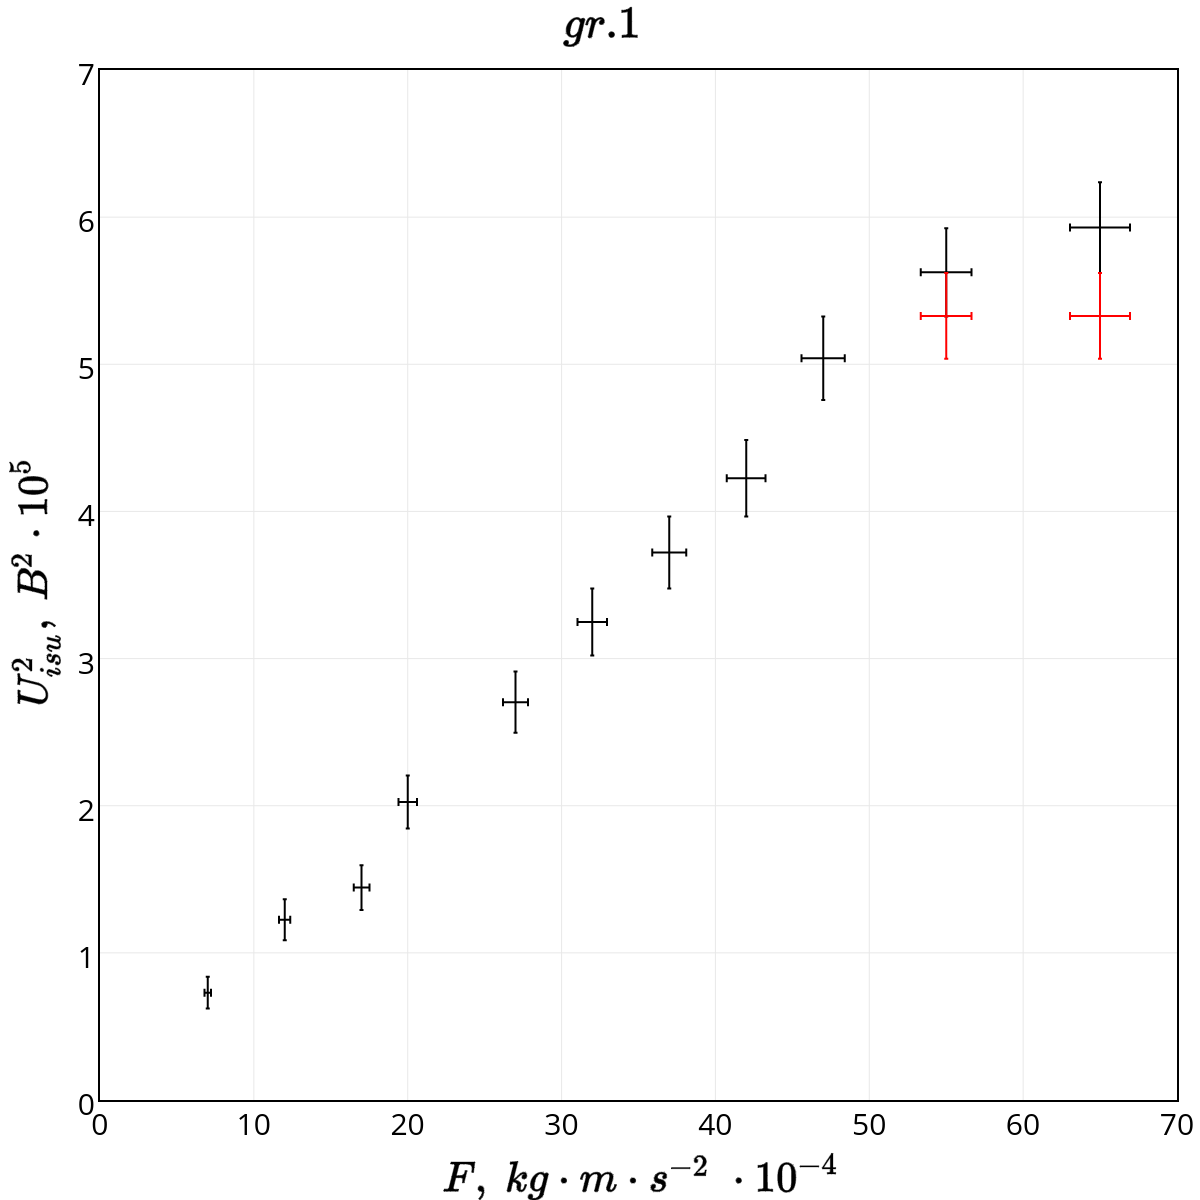

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#ff0000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#ff0000',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#ff0000'
    )
)

trace0 = [trace1, trace2]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot0.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot0.png", width=500)

#### Анализ

Построим стартовую LS регрессию

#### Curve fit (without sigma)

In [11]:
X = np.reshape(np.array(data['feature3']), (1, len(np.array(data['feature3']))))
Y = np.reshape(np.array(data['feature4']), (1, len(np.array(data['feature4']))))

In [12]:
def f(x, b):
    return b*x
parameters_opt_1, parameters_cov_1 = opt.curve_fit(f, X[0], Y[0])
parameters_opt_1 = parameters_opt_1[0]
parameters_sigma_1 = np.sqrt(np.diag(parameters_cov_1))[0]

In [13]:
print "y  = ({:.3f})*x".format(parameters_opt_1)
print "(+-)({:.3f})*x".format(parameters_sigma_1)

y  = (99076705.798)*x
(+-)(1840983.209)*x


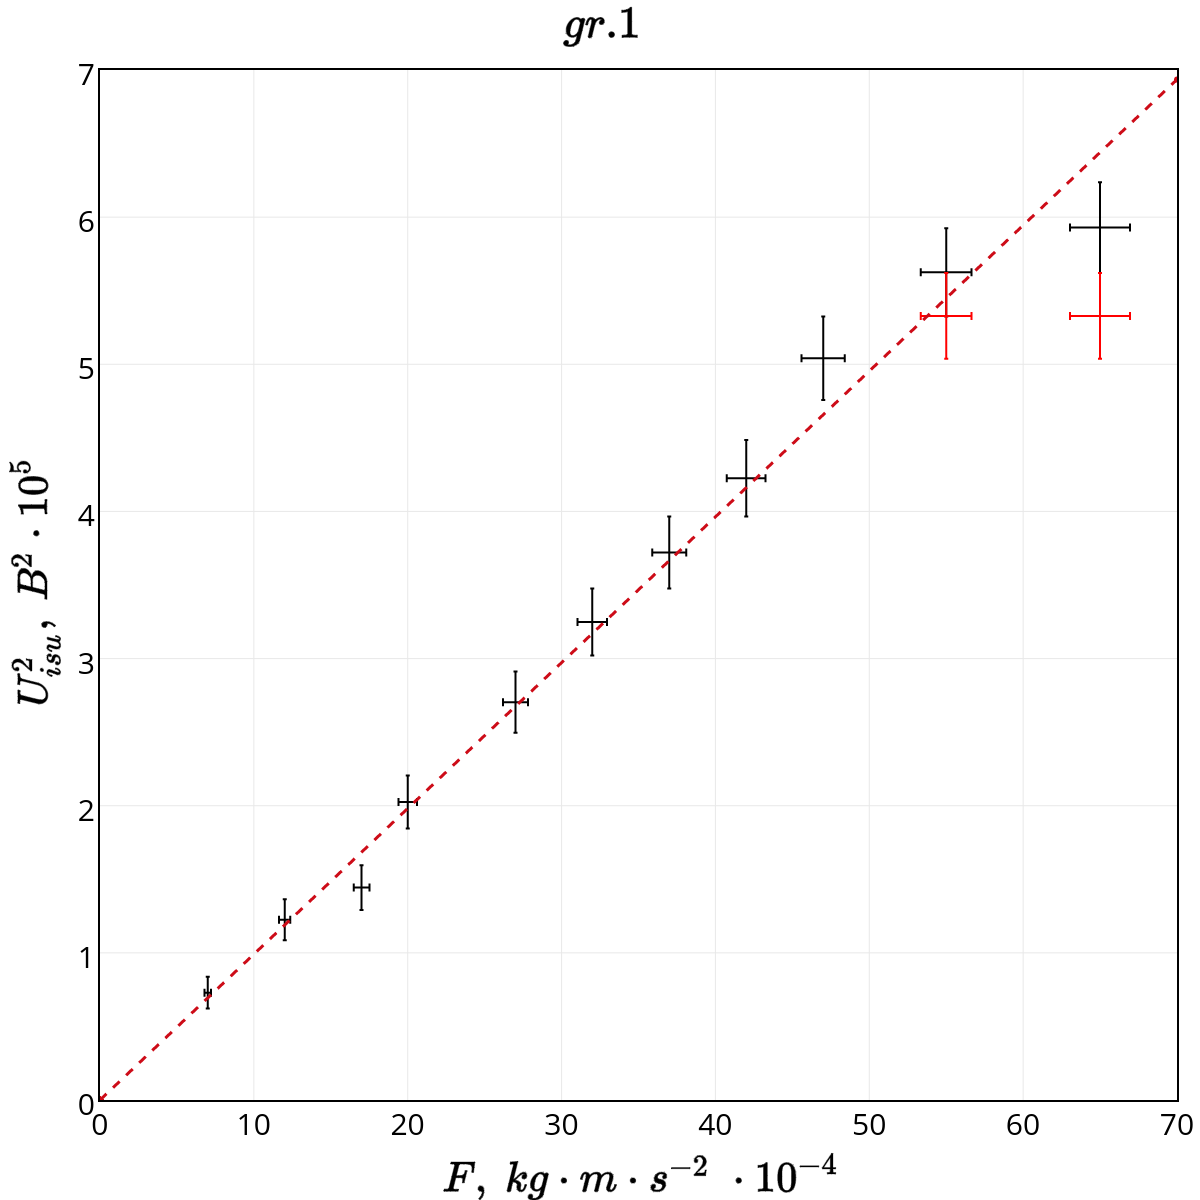

In [14]:
trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.0001, 0.0007*parameters_opt_1*0.0001],
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = [0.0*10000.0, 0.0007*10000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)

trace7 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)


trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#ff0000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#ff0000',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#ff0000'
    )
)

trace0 = [trace1, trace2, trace3] #, trace4, trace5, trace6, trace7]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot1.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot1.png", width=500)

По данной модели построим распределение остатков/ошибок на данных

In [15]:
err = pd.DataFrame()
err.insert(0, '0', data['feature4']-parameters_opt_1*data['feature3'])
err.insert(1, '1', data['feature3'])

In [16]:
err

,0,1
0,3546.305941,0.0007
1,3607.953043,0.0012
2,4346.588404,0.0020
3,2892.894346,0.0027
4,7854.541447,0.0032
5,5516.188548,0.0037
6,6377.835649,0.0042
7,38439.482750,0.0047
10,-24030.399856,0.0017
11,-51098.587686,0.0065


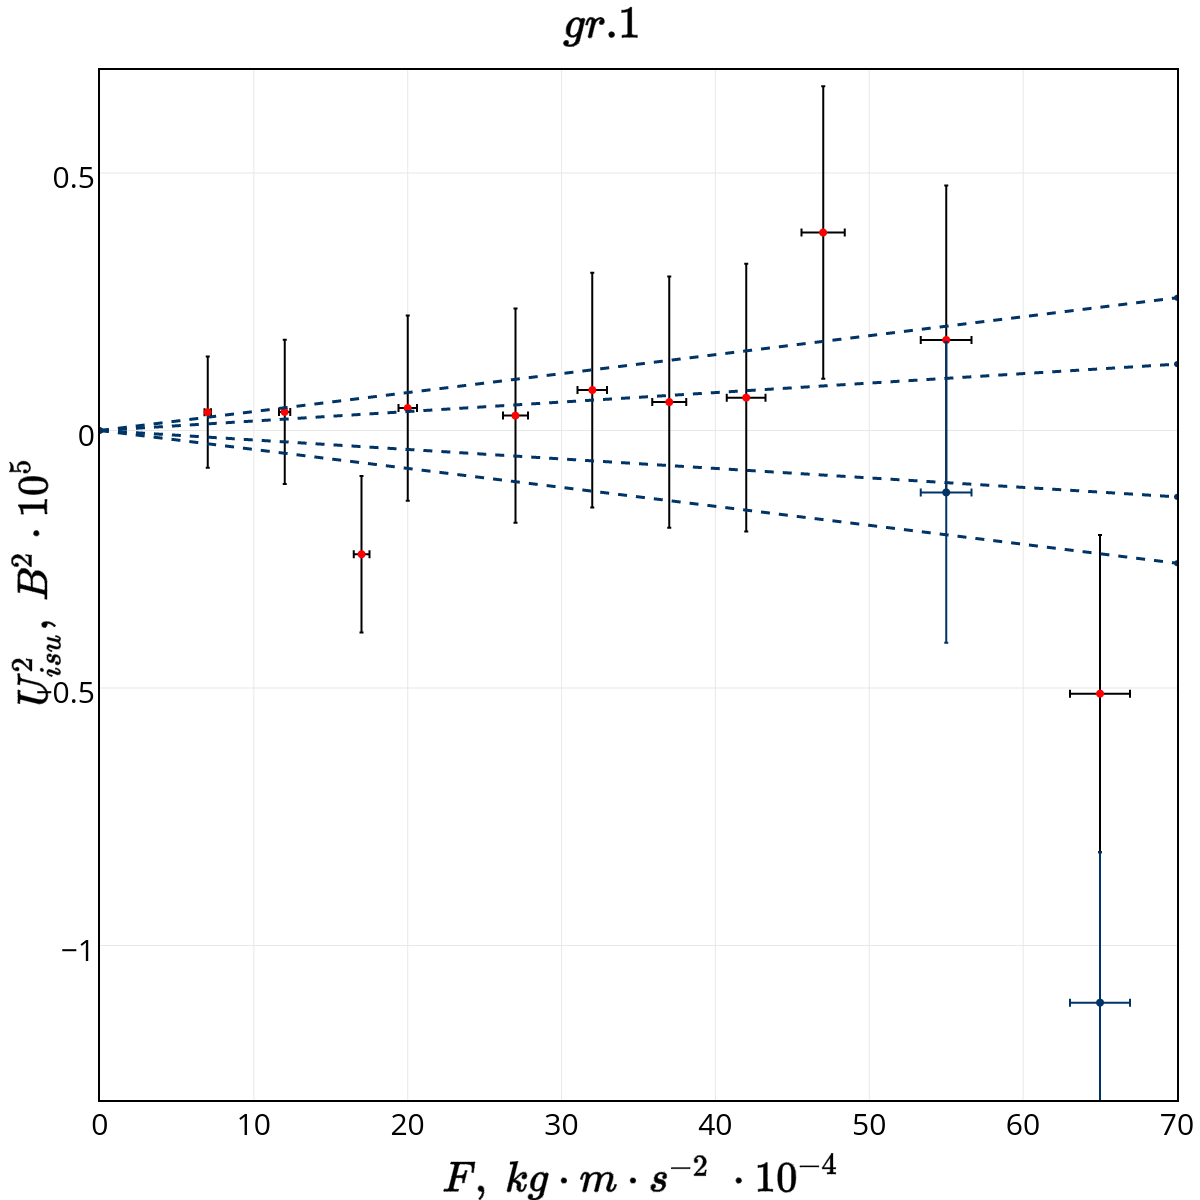

In [17]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = err['1']*10000,
    y = err['0']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 8,
        opacity = 1,
        color = '#ff0000'
    )
)

trace2 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),#51d9c5
        width = 3,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, -0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),#51d9c5
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, -2*0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 2*0.0007*parameters_sigma_1*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = data_e['feature3']*10000,
    y = (data_e['feature4']-parameters_opt_1*data_e['feature3'])/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#003366',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#003366',
    ),
    marker = dict(
        size = 8,
        opacity = 1,
        color = '#003366'
    )
)


trace0 = [trace1, trace2, trace3, trace4, trace5, trace6]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 30,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [-1.3, 0.7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 40,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 100,
        r = 23,
        t = 70,
        b = 100,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot2.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot2.png", width=500)

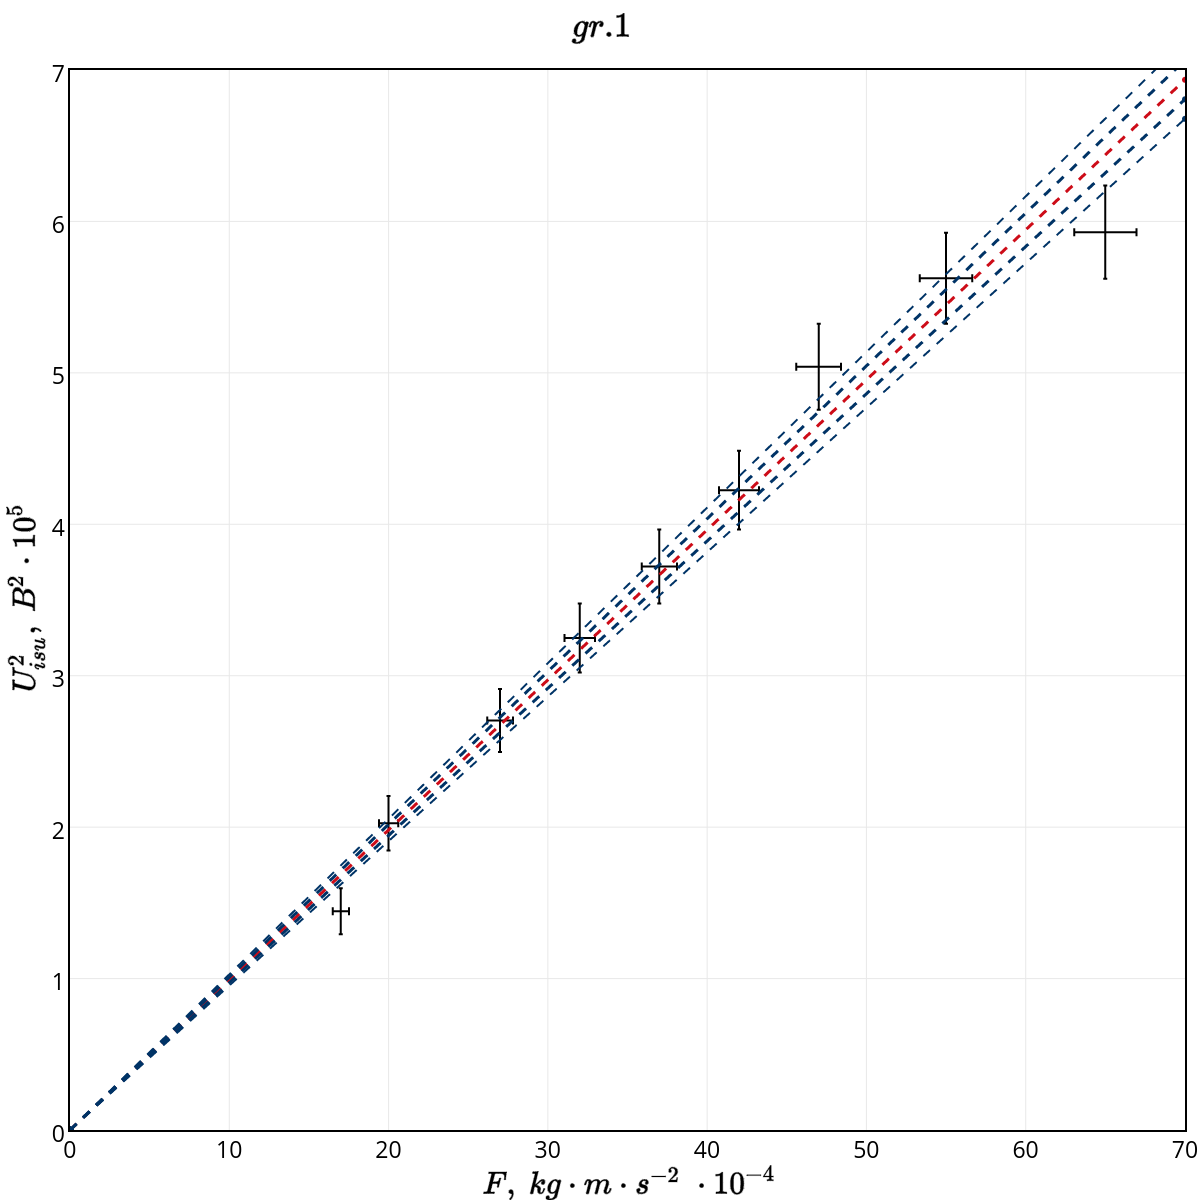

In [26]:
trace3 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.0001, 0.0007*parameters_opt_1*0.0001],
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 3,
        dash = 'dash')
)

trace4 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace5 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 3,
        dash = 'dash')
)

trace6 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1-2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)

trace7 = go.Scatter(
    x = [0.0*100000.0, 0.0007*100000.0],
    y = [0.0*0.00001, 0.0007*(parameters_opt_1+2*parameters_sigma_1)*0.0001],
    line = dict(
        color = ('#003366'),
        width = 2,
        dash = 'dash')
)


trace1 = go.Scatter(
    x = data['feature3']*10000,
    y = data['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data['feature7']/100000,
        visible = True,
        color = '#000000',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data['feature6']*10000,
        visible = True,
        color = '#000000'
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#000000'
    )
)
trace2 = go.Scatter(
    x = data_e['feature3']*10000,
    y = data_e['feature4']/100000,
    mode = 'markers',
    name = 'gr1',
    error_y = dict(
        type = 'data',
        array = data_e['feature7']/100000,
        visible = True,
        color = '#FFFF00',
        thickness = 2,
        width = 2
    ),
    error_x = dict(
        type = 'data',
        array = data_e['feature6']*10000,
        visible = True,
        color = '#FFFF00',
    ),
    marker = dict(
        size = 1,
        opacity = 1,
        color = '#FFFF00'
    )
)

trace0 = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]

layout = go.Layout(
    title = "$gr.1$",
    width = 1200,
    height = 1200,
    font = dict(
        size = 23,
        color = '#000000'
        ),
    showlegend=False,
    paper_bgcolor = '#ffffff',
    xaxis = dict(
        title = '$F,~kg \cdot m \cdot s^{-2}~\cdot 10^{-4}$',
        range = [0, 70],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 30,
            color = '#000000' 
            )
    ),
    yaxis = dict(
        title = '$U_{isu}^2,~B^2 \cdot 10^5$',
        range = [0, 7],
        zeroline = False,
        ticklen = 0,
        color = '#000000',
        mirror = True,
        showline = True,
        linewidth = 2,
        titlefont = dict(
            size = 30,
            color = '#000000' 
            )
    ),
    margin = dict(
        l = 70,
        r = 15,
        t = 70,
        b = 70,
        pad = 0 
    )
    
)

fig = go.Figure(data=trace0, layout=layout)
#py.iplot(figure, filename='basic-error-bar')
py.image.save_as(fig, 'my_plot3.png')
#! open my_plot.png
from IPython.display import Image
Image("my_plot3.png", width=500)

Исходя из определённых соображений описанных в тексте работы, удалим последнюю точку

In [21]:
data_e1 = data[data.index == 11]
data = data.drop(data.index == 11)

In [25]:
data.drop(data.index == 3)
data

ValueError: labels [False  True False False False False False False False] not contained in axis

In [ ]:
data_e = data.add(data[data.index == 11])
data = data.drop(data.index == 11)
err = err.drop(data.index == 11)

In [ ]:
err

Ошибка для электрической постоянной:

In [ ]:
e = 2*(d*d)/(s*parameters_opt[0])
print e

In [ ]:
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

t-критерий Стьюдента, но уже без последнего измерения:

In [ ]:
from statsmodels.stats.weightstats import *
import scipy

In [ ]:
print scipy.stats.ttest_1samp(err['0'], 0.0)
print zconfint(err['0'])

In [ ]:
print err

In [ ]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro(err['0'])

In [ ]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro([3546.305941, 3607.953042, 
                                                                                         4346.588404, 2892.894345, 
                                                                                         7854.541446, 5516.188547, 
                                                                                         6377.835648])

In [ ]:
err['0']*data['feature7'].apply(np.reciprocal)

In [ ]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % scipy.stats.shapiro([0.328362, 0.257711 ,0.241477, 
                                                                                         0.139081, 0.344497, 0.226073,
                                                                                         0.245301])

In [ ]:
err1 = err.drop([10])
err1 = err1.drop([12])
err1 = err1.drop([7])

print err1

data1 = data.drop([10])
data1 = data1.drop([12])
data1 = data1.drop([7])

print data1

#### Построение моделей


In [ ]:
X = np.reshape(np.array(data['feature3']), (1, len(np.array(data['feature3']))))
Y = np.reshape(np.array(data['feature4']), (1, len(np.array(data['feature4']))))
Xerr = np.reshape(np.array(data['feature6']), (1, len(np.array(data['feature6']))))
Yerr = np.reshape(np.array(data['feature7']), (1, len(np.array(data['feature7']))))
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]) #, sigma = Yerr[0], absolute_sigma=True)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

In [ ]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0], sigma = Yerr['0'], absolute_sigma=False)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

In [ ]:
def linear_func(b, x):
     return b[0]*x

linear_model = odr.Model(linear_func)

data = odr.RealData(X, Y, sx=Xerr, sy=Yerr)

my_odr = odr.ODR(data, linear_model, beta0=[99000000])

out = my_odr.run()

out.pprint()

In [ ]:
X = np.reshape(np.array(data1['feature3']), (1, len(np.array(data1['feature3']))))
Y = np.reshape(np.array(data1['feature4']), (1, len(np.array(data1['feature4']))))
Xerr = np.reshape(np.array(data1['feature6']), (1, len(np.array(data1['feature6']))))
Yerr = np.reshape(np.array(data1['feature7']), (1, len(np.array(data1['feature7']))))
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0]) #, sigma = Yerr[0], absolute_sigma=True)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

In [ ]:
def f(x, b):
    return b*x
parameters_opt, parameters_cov = opt.curve_fit(f, X[0], Y[0], sigma = Yerr['0'], absolute_sigma=False)
print("y  = ({:.3f})*x".format(parameters_opt[0]))
print("(+-)({:.3f})*x".format(np.sqrt(np.diag(parameters_cov))[0]))
sigma_syst_e = 2*e*sigma_syst_d/d + e*sigma_syst_s/s
sigma_stat_e = (np.sqrt(np.diag(parameters_cov))[0])/parameters_opt[0] * e
print (sigma_syst_e)
print (sigma_stat_e)
sigma_e = sqrt(sigma_syst_e*sigma_syst_e + sigma_stat_e*sigma_stat_e)
print sigma_e*10**12

In [ ]:
def linear_func(b, x):
     return b[0]*x

linear_model = odr.Model(linear_func)

data = odr.RealData(X, Y, sx=Xerr, sy=Yerr)

my_odr = odr.ODR(data, linear_model, beta0=[99000000])

out = my_odr.run()

out.pprint()

In [ ]:
answer =  (99076705.798 + 99142582.544 + 99334971 + 100822412.811 + 100998666.595 + 1.01028915e+08)/6
print answer

In [ ]:
e = 2*(d*d)/(s*answer)
print e